In [15]:
import os
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
import time
import json 
import statistics
import matplotlib.pyplot as plt
import numpy as np
from progress.bar import Bar
from scipy.signal import savgol_filter

In [2]:
%matplotlib notebook

## Check to make sure files were downloaded correctly

It's possible that some downloads downloaded incorrectly. If this is the case, the 'success' field of the JSON will be false. 

In [8]:
def check_downloads():
    suc_down = {}

    tot = 0
    fal = 0

    for cstock in os.listdir("data/"):
        for fname in os.listdir(os.path.join("data", cstock)):
            tot+=1
            cpth = os.path.join("data", cstock, fname)

            splt = fname.split("-")

            year = int(splt[0])
            month = int(splt[1])
            day = int(splt[2])

            cdate = date(year, month, day)

            if cstock not in suc_down.keys():
                suc_down[cstock] = {}

            success = True
            for cfl in os.listdir(cpth):
                with open(os.path.join(cpth, cfl)) as f:
                    data = json.load(f)
                    if not data['success']:
                        success = False
                        fal+=1
                        break

            if success:
                suc_down[cstock][cdate] = cpth



    print("{}/{} Failed".format(fal, tot))
    return suc_down

In [9]:
suc_down = check_downloads()
dates = list(suc_down['NFLX'].keys())
dates.sort(reverse=True)
print("Dates that sucessfully downloaded: ", [str(dd) for dd in dates])

0/70 Failed
Dates that sucessfully downloaded:  ['2020-04-06', '2020-04-03', '2020-04-02', '2020-04-01', '2020-03-31', '2020-03-30', '2020-03-27']


## Load data in one day at a time

In [10]:
def load_date(dd):
    res = {}
    
    for cstock in suc_down.keys():
        res[cstock] = {}
        
        fst = True
        
        foo = os.listdir(suc_down[cstock][dd])
        foo.sort()

        for fname in foo:
            cpth = os.path.join(suc_down[cstock][dd], fname)
            with open(cpth) as f:
                data = json.load(f)

                if not data['success']:
                    print("Big Error")
                agg_ticks = {k: [dic[k] for dic in data['results'] if dic['x'] != 4] for k in data['results'][0] if k not in ['c', 'f', 'r']}
                
                for kk in agg_ticks.keys():
                    if fst:
                        res[cstock][data['map'][kk]['name']] = agg_ticks[kk]
                    else:
                        res[cstock][data['map'][kk]['name']].extend(agg_ticks[kk])
                fst=False
                        
    return res

def getdt(timestamp):
    #input timestep in nanoseconds
    return datetime.fromtimestamp(timestamp*1e-9)

def getmin(timestamp):
    return timestamp*1e-9/60

def gethor(timestamp):
    return timestamp*1e-9/360

def getminlst(lst):
    inn = lst[0]
    return list(map(lambda x: (x-inn)*1e-9*0.001/60, lst))

def gethorlst(lst):
    inn = lst[0]
    return list(map(lambda x: (x-inn)*2.77778e-13, lst))

def norm_price(lst, lead = 1000, offset = 100):
    avg = statistics.mean(lst[offset:lead+offset])
    return list(map(lambda x: x/avg - 1, lst))

## Data analysis on single day

In [11]:
one_day = load_date(dates[0])
print("Stocks availible: ", one_day.keys())
print("Checking to make sure ")
for cstock in one_day.keys():
    print(cstock, ": ", datetime.fromtimestamp(one_day[cstock]['sip_timestamp'][0]*1e-9), " -- ", 
        datetime.fromtimestamp(one_day[cstock]['sip_timestamp'][-1]*1e-9))

Stocks availible:  dict_keys(['AMZN', 'AAPL', 'CMCSA', 'GOOG', 'INTC', 'FB', 'GOOGL', 'MSFT', 'NFLX', 'CSCO'])
Checking to make sure 
AMZN :  2020-04-06 08:30:00.024616  --  2020-04-06 14:59:59.978058
AAPL :  2020-04-06 08:30:00.000340  --  2020-04-06 14:59:59.992094
CMCSA :  2020-04-06 08:30:00.009700  --  2020-04-06 14:59:59.996177
GOOG :  2020-04-06 08:30:00.131074  --  2020-04-06 14:59:59.997861
INTC :  2020-04-06 08:30:00.001721  --  2020-04-06 14:59:59.999237
FB :  2020-04-06 08:30:00.005846  --  2020-04-06 14:59:59.942766
GOOGL :  2020-04-06 08:30:00.107655  --  2020-04-06 14:59:59.999972
MSFT :  2020-04-06 08:30:00.007180  --  2020-04-06 14:59:59.999828
NFLX :  2020-04-06 08:30:00.017373  --  2020-04-06 14:59:59.992100
CSCO :  2020-04-06 08:30:00.000626  --  2020-04-06 14:59:59.999384


<IPython.core.display.Javascript object>


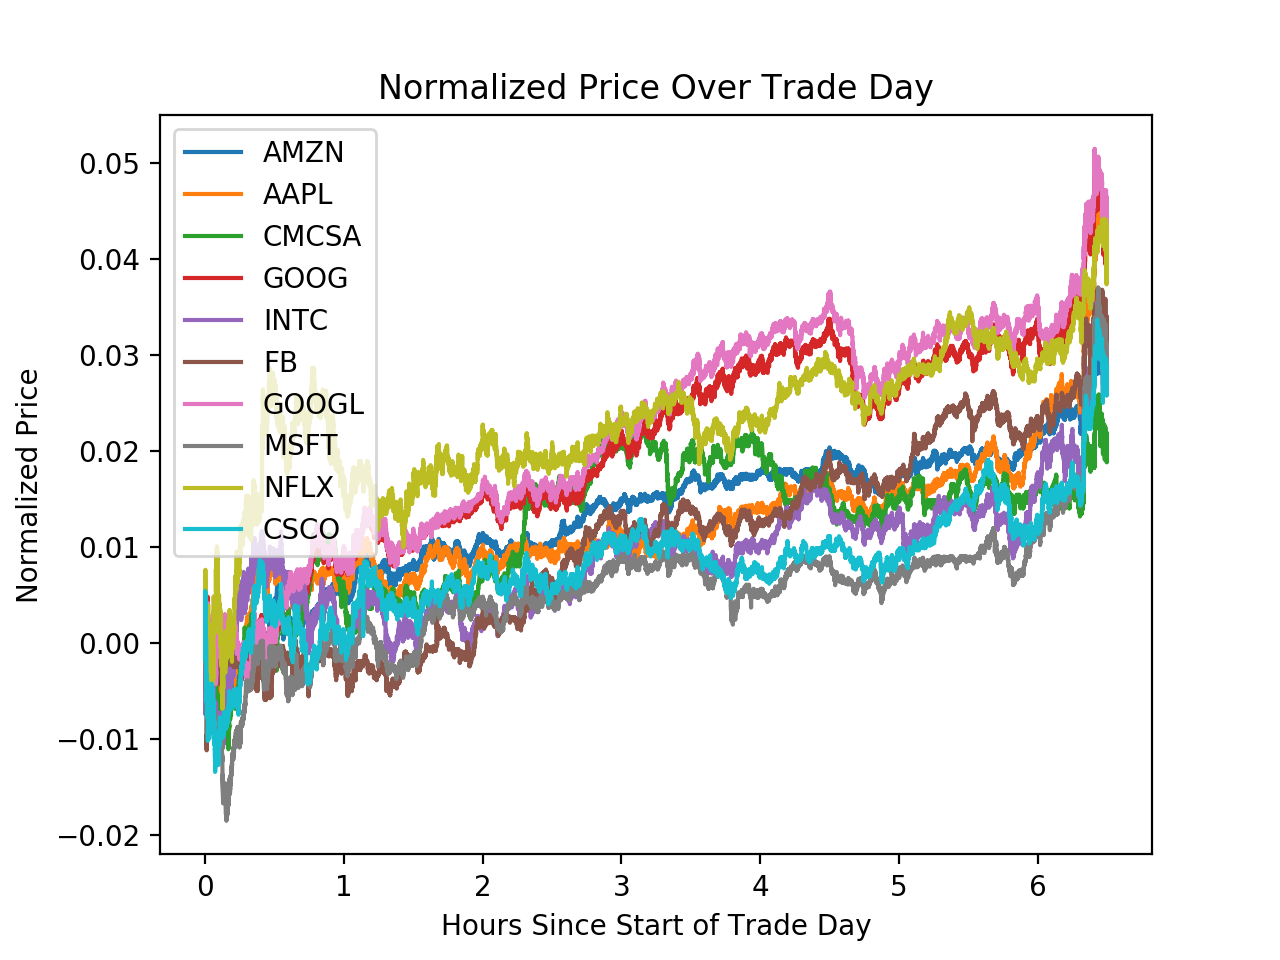

AMZN : samples= 93349
AAPL : samples= 322646
CMCSA : samples= 124521
GOOG : samples= 48582
INTC : samples= 175339
FB : samples= 163603
GOOGL : samples= 58086
MSFT : samples= 327068
NFLX : samples= 73558
CSCO : samples= 125013


/Users/danielborders/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # Remove the CWD from sys.path while we load stuff.


In [65]:
plt.figure()
for cstock in one_day.keys():
    plt.plot(gethorlst(one_day[cstock]['sip_timestamp']), norm_price(one_day[cstock]['price']))
    print(cstock, ": samples=", len(one_day[cstock]['sip_timestamp']))
    
plt.legend(list(one_day.keys()))
plt.title("Normalized Price Over Trade Day")
plt.ylabel("Normalized Price")
plt.xlabel("Hours Since Start of Trade Day")
plt.savefig("example_images/cover_plot.png")

### Code to generate a mean. 
Generating a mean line proved to be a difficult task because each stock is sampled at a different times, volumes and rates. As a result, a function to create a time based mean of all 10 stocks was created. This algorithm works by selecting the least sampled stock as the template. 3 trades of the templars are iterated linearly. The timestamps of the first and the third trade are used as the start and stop time. For each stock, the volume weighted average price and the total volume is computed in this timeframe. The volume weighted average of these numbers was computed for the 10 stocks. The mean time of the first and second trade was used for the “x” value. An example is shown in Figure 3 of this mean. Strategies involving this mean line were not profitable since the stock’s profitability diverged during early trading.

In [17]:
def gen_multifactor_mean(dicc):
    #normalizing prices 
    for cstock in dicc.keys():
        dicc[cstock]['price_n'] = norm_price(dicc[cstock]['price'])
        dicc[cstock]['sip_ts_np'] = np.array(dicc[cstock]['sip_timestamp'])
    
    least_dense = min(dicc, key = lambda kk: len(dicc[kk]['sip_timestamp']))
    print("Using {} to generate mean line".format(least_dense))
    
    stndx = [0]*(len(list(dicc.keys()))-1)
    
    ii = 1
    resx = []
    resy = []
    
    bar = Bar('Generating MeanLine', max=len(dicc[least_dense]['sip_timestamp'])-1)
    
    while ii < len(dicc[least_dense]['sip_timestamp'])-1:
        max_i = ii+1
        for foo in range (ii+1, len(dicc[least_dense]['sip_timestamp'])):
            if dicc[least_dense]['sip_timestamp'][max_i] == dicc[least_dense]['sip_timestamp'][max_i+1]:
                max_i += 1
            else:
                break
        base_p = statistics.mean(dicc[least_dense]['price_n'][ii-1:max_i])
        base_v = statistics.mean(dicc[least_dense]['size'][ii-1:max_i])
        
#         print("st")
#         print(dicc[least_dense]['sip_timestamp'][ii-1], dicc[least_dense]['sip_timestamp'][max_i])
        
        mean_ps = []
        mean_vs = []
        
        # Iterate throught the rest of the stocks not including the least densly sampled one
        for jj, cstock in enumerate([kk for kk in dicc.keys() if kk != least_dense]):
            idst = np.argwhere(dicc[cstock]['sip_ts_np'] <= dicc[least_dense]['sip_timestamp'][ii-1])
            if len(idst) == 0: idst = 0
            else: idst = idst[-1][0]
                
            iden = np.argwhere(dicc[cstock]['sip_ts_np'] >= dicc[least_dense]['sip_timestamp'][max_i])
            
            if len(iden) == 0: iden = len(dicc[least_dense]['sip_timestamp'])-1
            else: iden = iden[0][0]
            
            try:
                mean_ps.append(statistics.mean(dicc[cstock]['price_n'][idst:iden]))
                mean_vs.append(statistics.mean(dicc[cstock]['size'][idst:iden]))
            except:
                mean_ps.append(0)
                mean_vs.append(1)
                print("err")
            
            
        tot_vs = sum(mean_vs) + base_v
        
        mean_p = base_p * base_v/tot_vs
        mean_p += sum([p*k/tot_vs for p, k in zip(mean_ps, mean_vs)])
        
        
        resx.append(statistics.mean(dicc[least_dense]['sip_timestamp'][ii-1:max_i]))
        resy.append(mean_p)
        
        for pp in range(ii, max_i+1):
            bar.next()
        
        ii=max_i+1
        
        
    bar.finish() 
    return resx, resy

In [18]:
X, Y = gen_multifactor_mean(one_day)

Using GOOG to generate mean line
err
err
err
err
err
err
err


In [19]:
#validate that it spans the entire trading day
print("start--end: ", datetime.fromtimestamp(X[0]*1e-9), " -- ", 
        datetime.fromtimestamp(X[-1]*1e-9))

start--end:  2020-04-06 08:30:00.225872  --  2020-04-06 14:59:59.960449


<IPython.core.display.Javascript object>


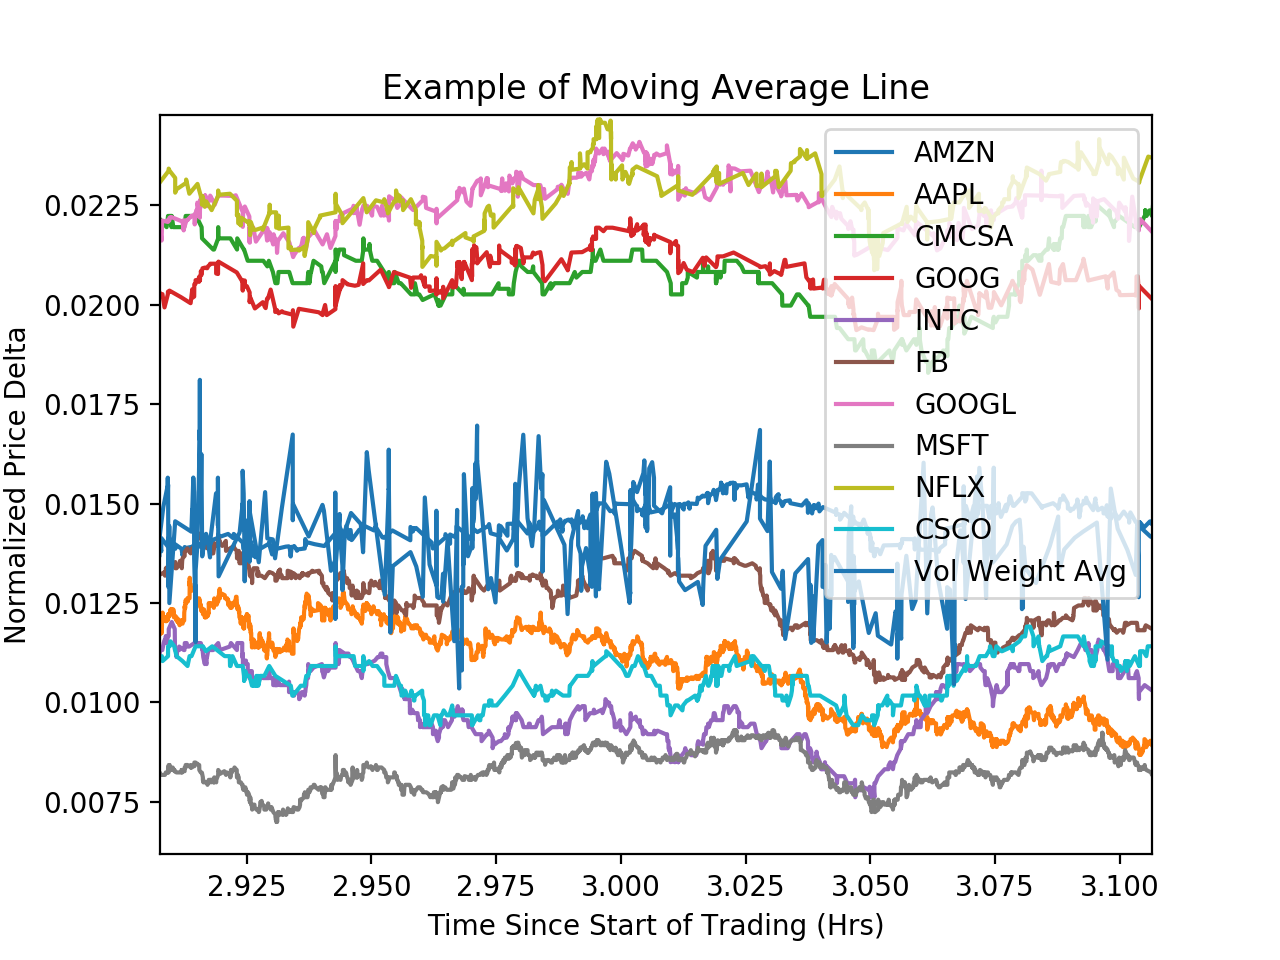

In [20]:
legend = []
plt.figure()
for cstock in one_day.keys():
    plt.plot(gethorlst(one_day[cstock]['sip_timestamp']), norm_price(one_day[cstock]['price']))
    legend.append(cstock)

legend.append("Vol Weight Avg")

plt.plot(gethorlst(X), Y)
plt.xlabel("Time Since Start of Trading (Hrs)")
plt.ylabel("Normalized Price Delta")
plt.title("Example of Moving Average Line")
plt.legend(legend)

### This is a bit shakey, so lets smooth. 

<IPython.core.display.Javascript object>


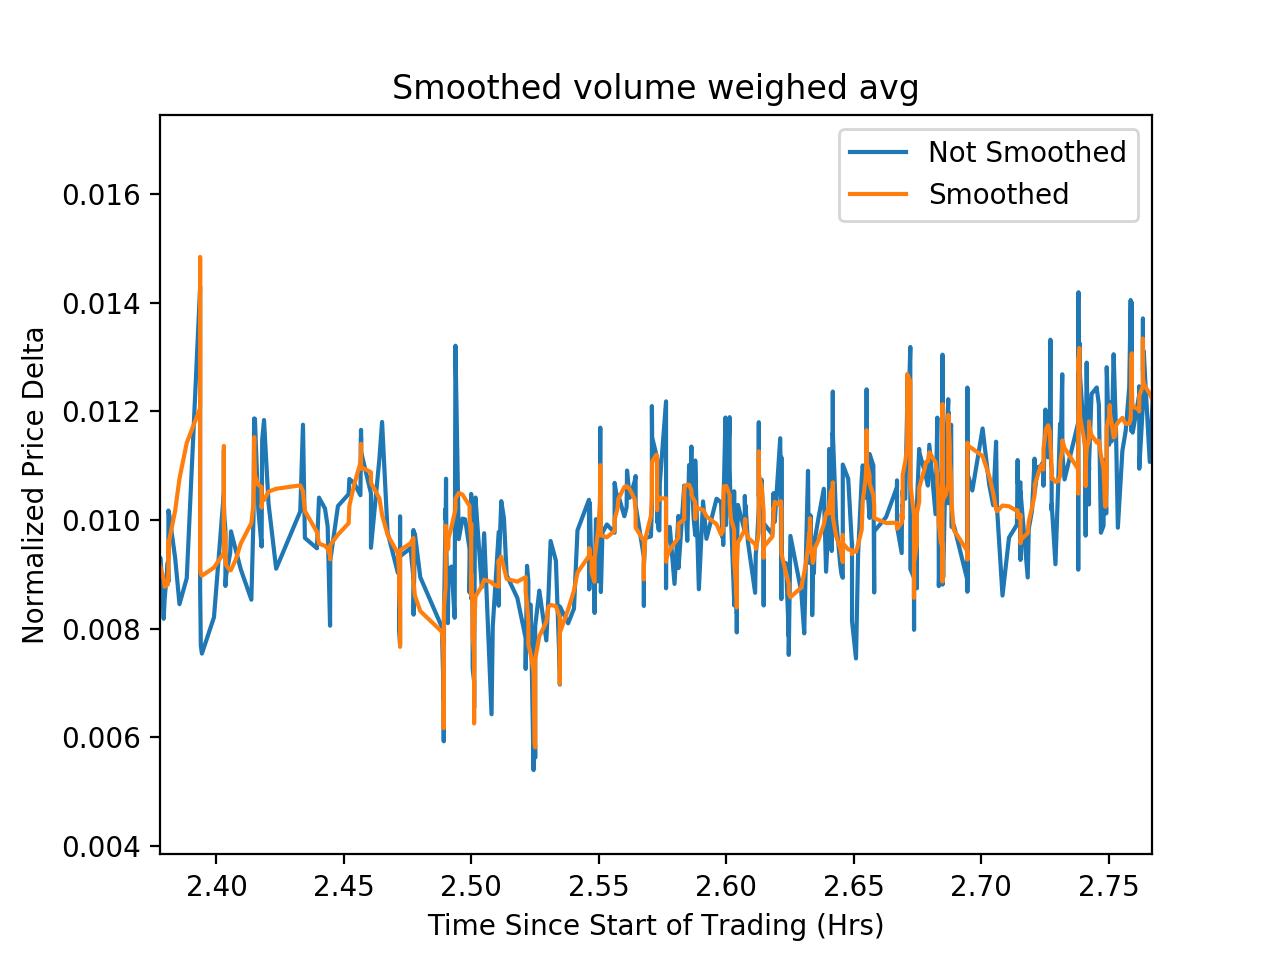

In [24]:
Y_sm = savgol_filter(Y, 15, 3)

plt.figure()
plt.plot(gethorlst(X), Y)
plt.plot(gethorlst(X), Y_sm)
plt.xlabel("Time Since Start of Trading (Hrs)")
plt.ylabel("Normalized Price Delta")
plt.title("Smoothed volume weighed avg")
plt.legend(['Not Smoothed', 'Smoothed'])

# Single Stock Momentum Strat

<IPython.core.display.Javascript object>


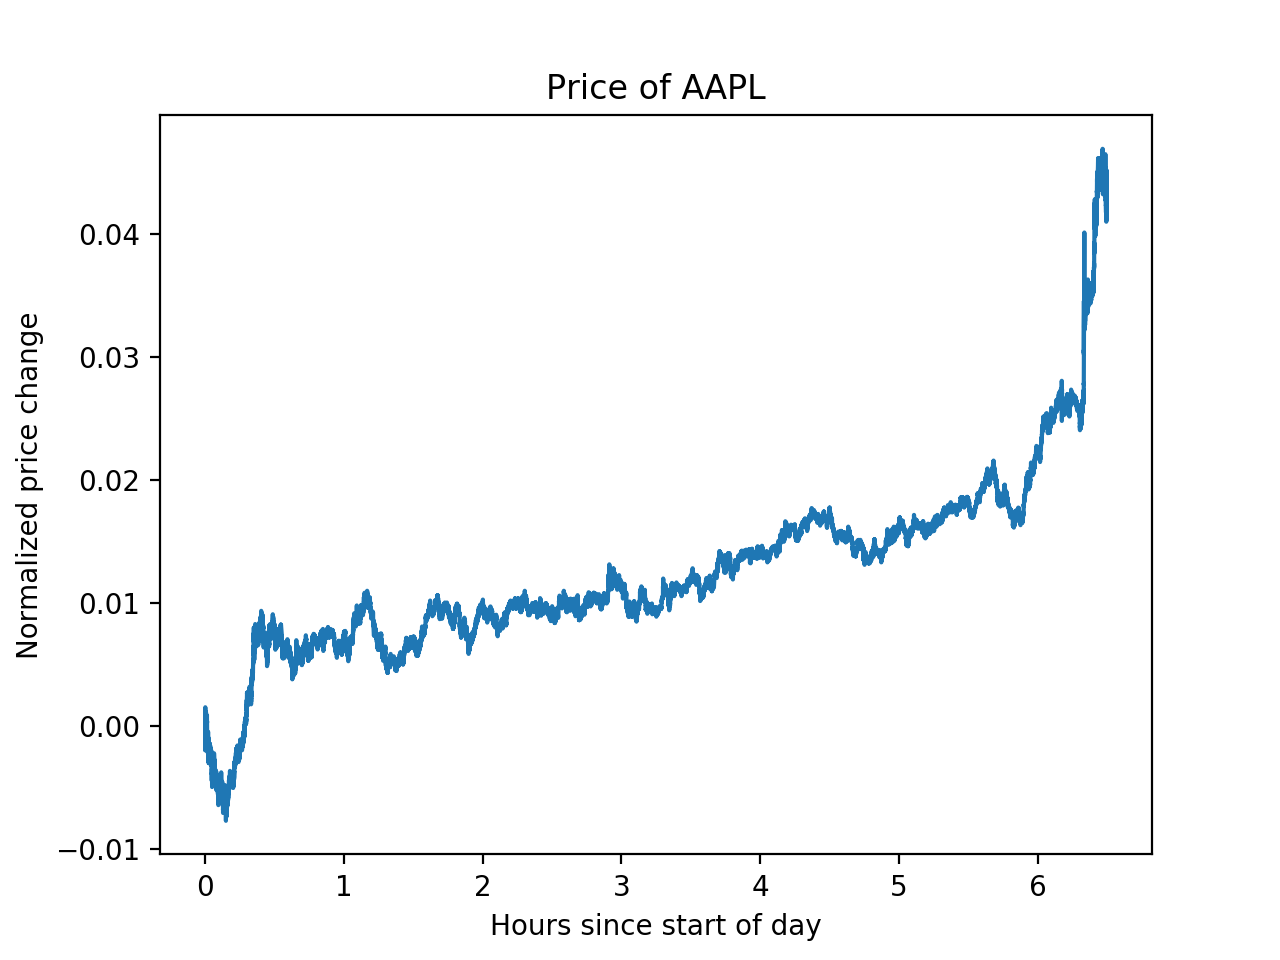

<IPython.core.display.Javascript object>


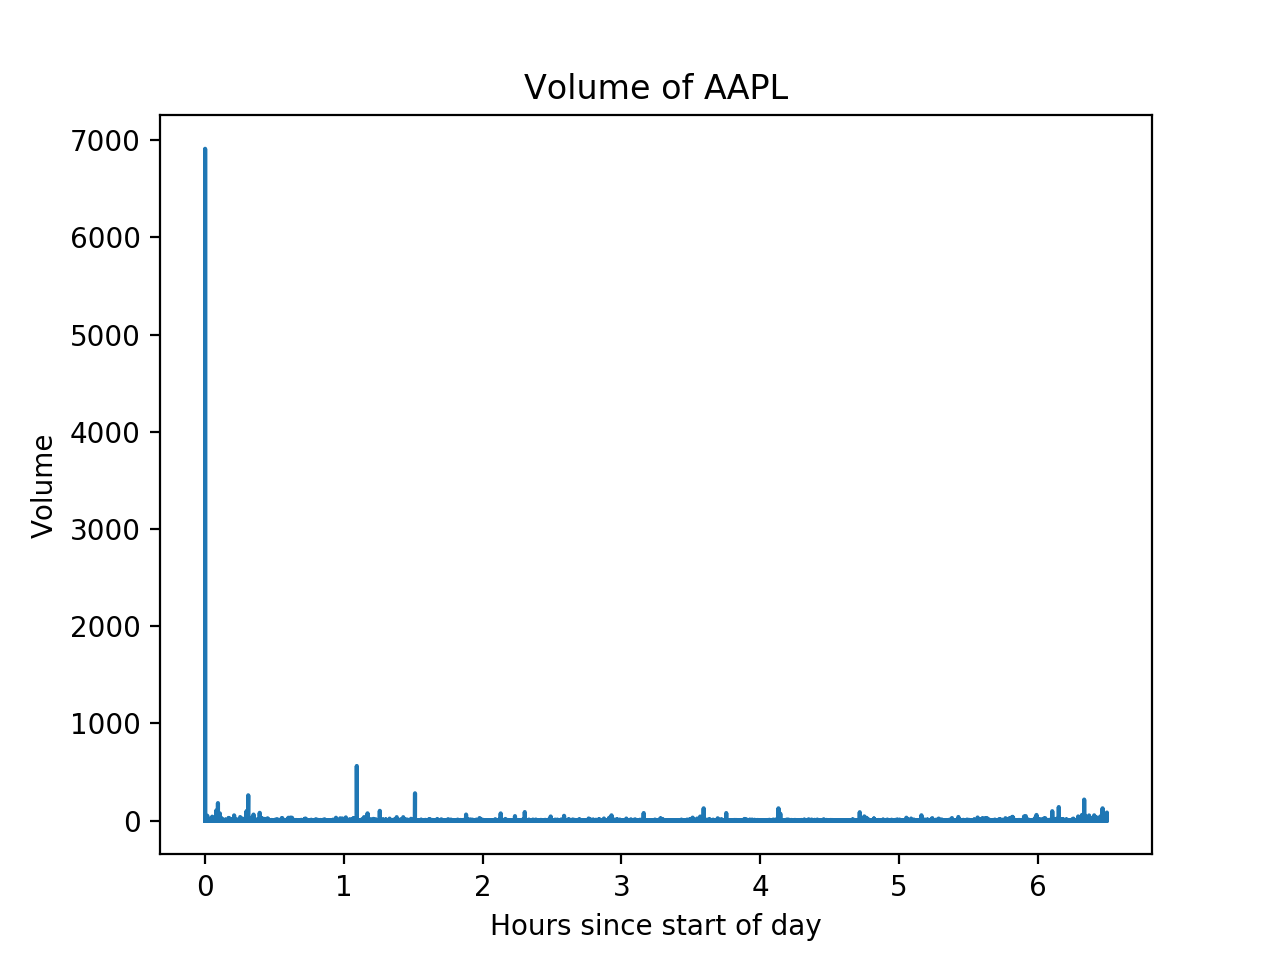

Text(0, 0.5, 'Volume')

In [25]:
plt.figure()

plt.plot(gethorlst(one_day['AAPL']['sip_timestamp']), norm_price(one_day['AAPL']['price']))
plt.title("Price of AAPL")
plt.xlabel("Hours since start of day")
plt.ylabel("Normalized price change")

plt.figure()

plt.plot(gethorlst(one_day['AAPL']['sip_timestamp']), norm_price(one_day['AAPL']['size']))
plt.title("Volume of AAPL")
plt.xlabel("Hours since start of day")
plt.ylabel("Volume")

### The super tall sparse trades are due to dark pool activity, lets remove them
Removed in line 19 of load data

In [27]:
#we elimintated these by removing all the dark pool trades
for ii in range(len(one_day['AAPL']['price'])):
    if one_day['AAPL']['price_n'][ii] < -.02:
        print([(kk, one_day['AAPL'][kk][ii]) for kk in one_day['AAPL'].keys() if kk not in ['tape', 'sip_timestamp', 'participant_timestamp']])

In [ ]:
with open('exchanges.json') as f:
    exc = json.load(f)
print(exc[4])

In [28]:
def get_avg_sig(osig, window=10):
    mean_mask = [1/window]*window
    return np.convolve(osig, mean_mask, mode='same')

In [39]:
def gen_mom_split(lst):
    mom_key = [0]
    for ii in range(1, len(out)):
        if lst[ii]>lst[ii-1]:
            mom_key.append(1)
        elif lst[ii]==lst[ii-1]:
            mom_key.append(0)
        elif lst[ii]<lst[ii-1]:
            mom_key.append(-1)
            
    prev = 0
    ii = 0
    mom_spl = {}
    mom_spl[-1]=[]; mom_spl[0]=[]; mom_spl[1]=[]
    while ii < len(mom_key):
        cnum = 0
        while ii < len(mom_key) and mom_key[ii] == mom_key[prev]:
            cnum += 1
            ii+=1

        mom_spl[mom_key[prev]].append(cnum)
        cnum = 0
        prev = ii
    return mom_spl, mom_key

In [32]:
out = get_avg_sig(norm_price(one_day['AAPL']['price']))

<IPython.core.display.Javascript object>


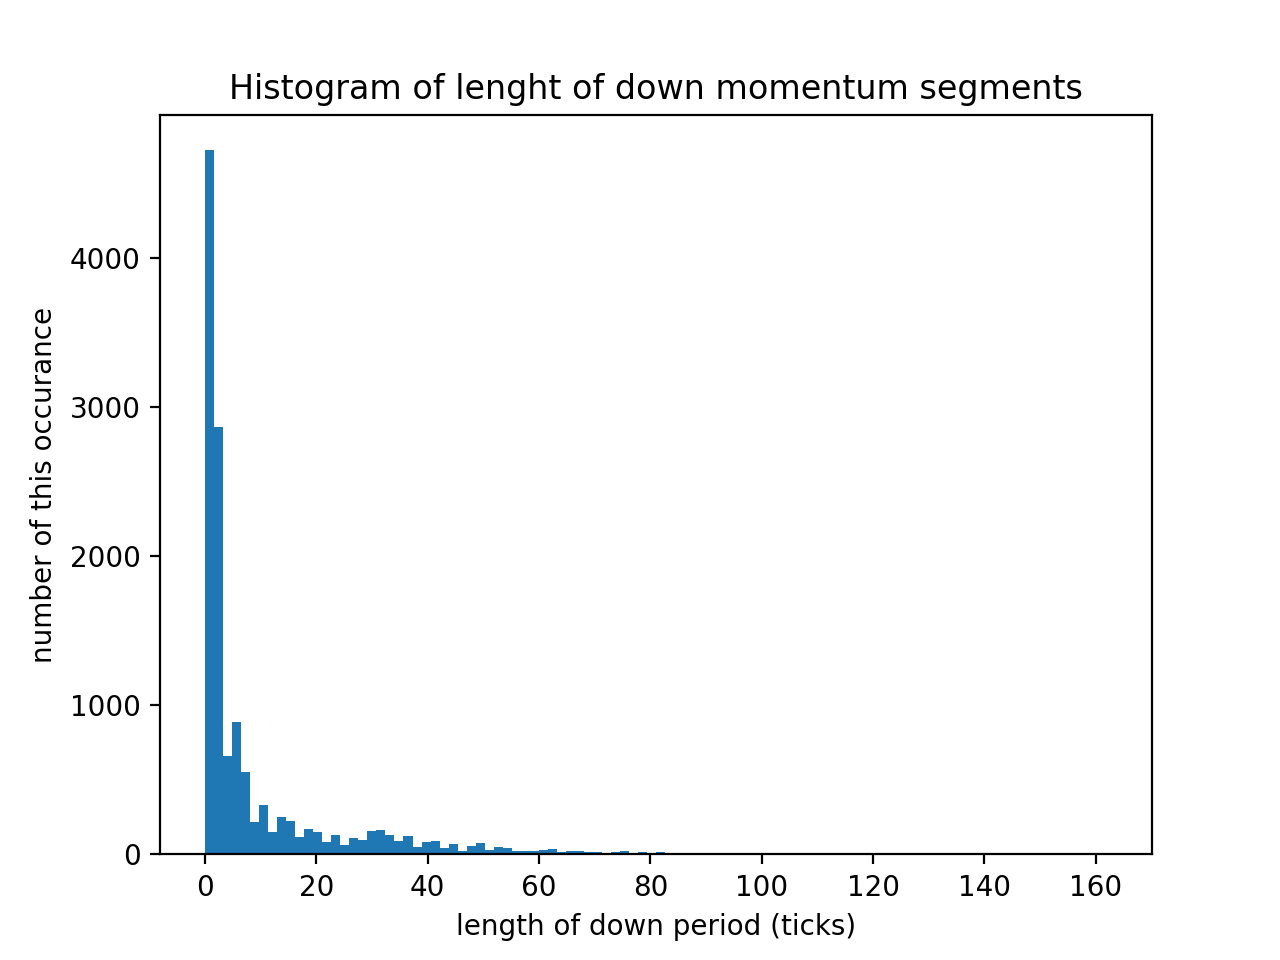

<IPython.core.display.Javascript object>


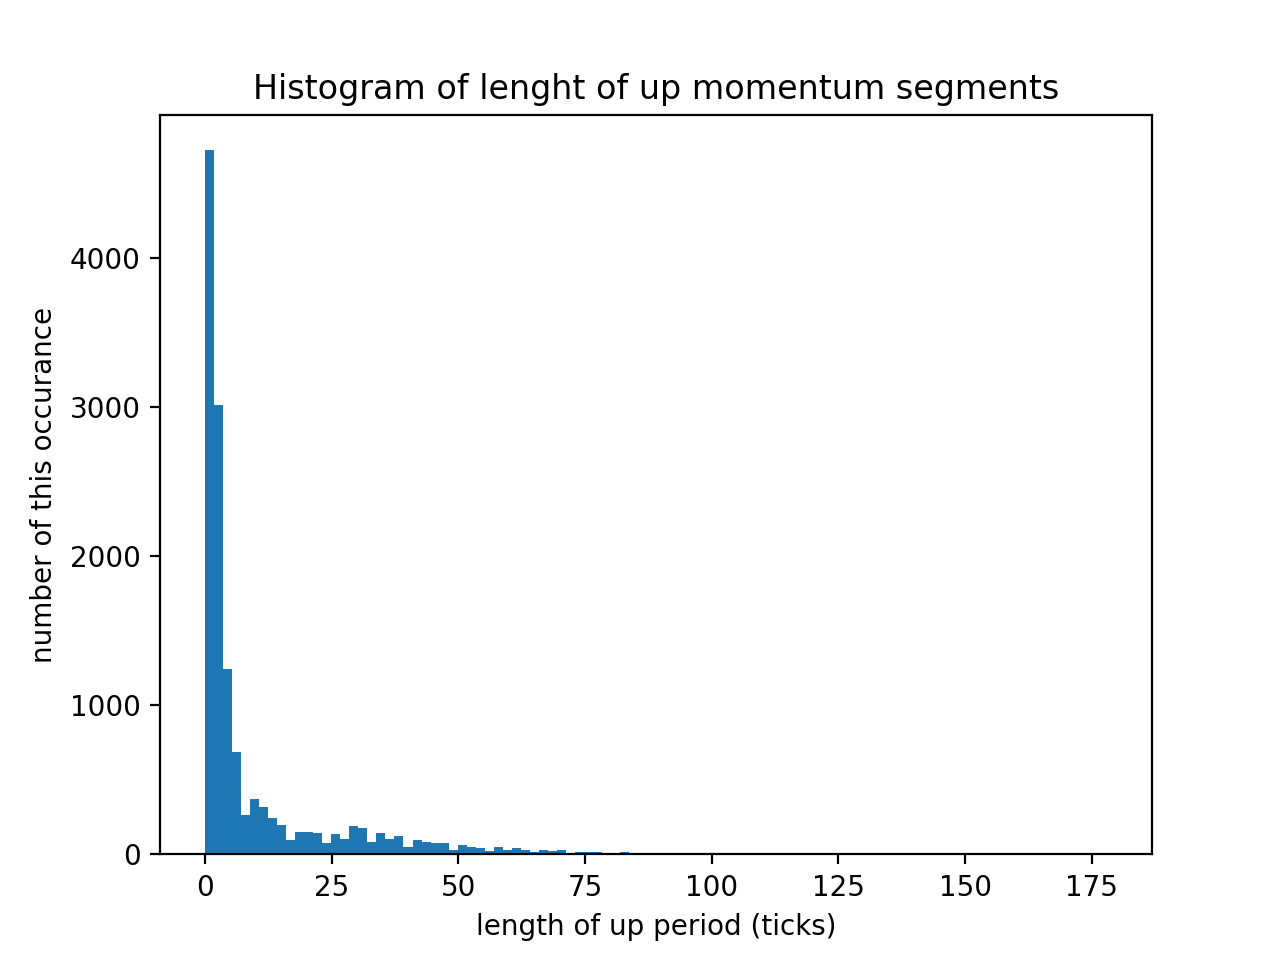

Text(0, 0.5, 'number of this occurance')

In [40]:
mom_spl, mom_key = gen_mom_split(get_avg_sig(one_day['AAPL']['price_n'], window=30))
plt.figure()
plt.title("Histogram of lenght of down momentum segments")
plt.hist(mom_spl[-1], bins=100, range=(0, max(mom_spl[-1])))
plt.xlabel("length of down period (ticks)")
plt.ylabel("number of this occurance")

plt.figure()
plt.title("Histogram of lenght of up momentum segments")
plt.hist(mom_spl[1], bins=100, range=(0, max(mom_spl[1])))
plt.xlabel("length of up period (ticks)")
plt.ylabel("number of this occurance")

# Momentum Strategy
Looking at the second graph below, it appers as if there is a hump around 105. This suggests that if we buy in the gully before the hump there is a high probability that the stock will make it to about 100 ticks. The numbers I will be using for following tests is the following. Buy once it hits 65 ticks then sell when it hits 105 ticks. In essence we are capturing the profits from the small rise. Worked better to hold untill there was a down tick.

In [41]:
def test_mom_at(buy_at, jump_by=100):

    csinfo = one_day['AAPL']


    prof = []
    durr = []

    ii = 0
    while ii < len(mom_key):
        # skip all the down and flat ticks
        if mom_key[ii] in [0, -1]:
            ii += 1
            continue

        num_in_row = 1
        while ii < len(mom_key) and mom_key[ii] == 1:
            num_in_row+=1

            if num_in_row >= buy_at:
                break

            ii+=1

        gg = 0
        while ii+gg < len(mom_key) and mom_key[ii+gg] in [1, 0]:
            gg+=1

        prof.append(csinfo['price'][ii+gg]-csinfo['price'][ii])
        durr.append((csinfo['sip_timestamp'][ii+gg]-csinfo['sip_timestamp'][ii])*1e-9)

        ii+= jump_by

#     print("Mean Profit = {}, Mean Duration = {}".format(statistics.mean(prof), statistics.mean(durr)))      
    return statistics.mean(prof), statistics.mean(durr)

<IPython.core.display.Javascript object>


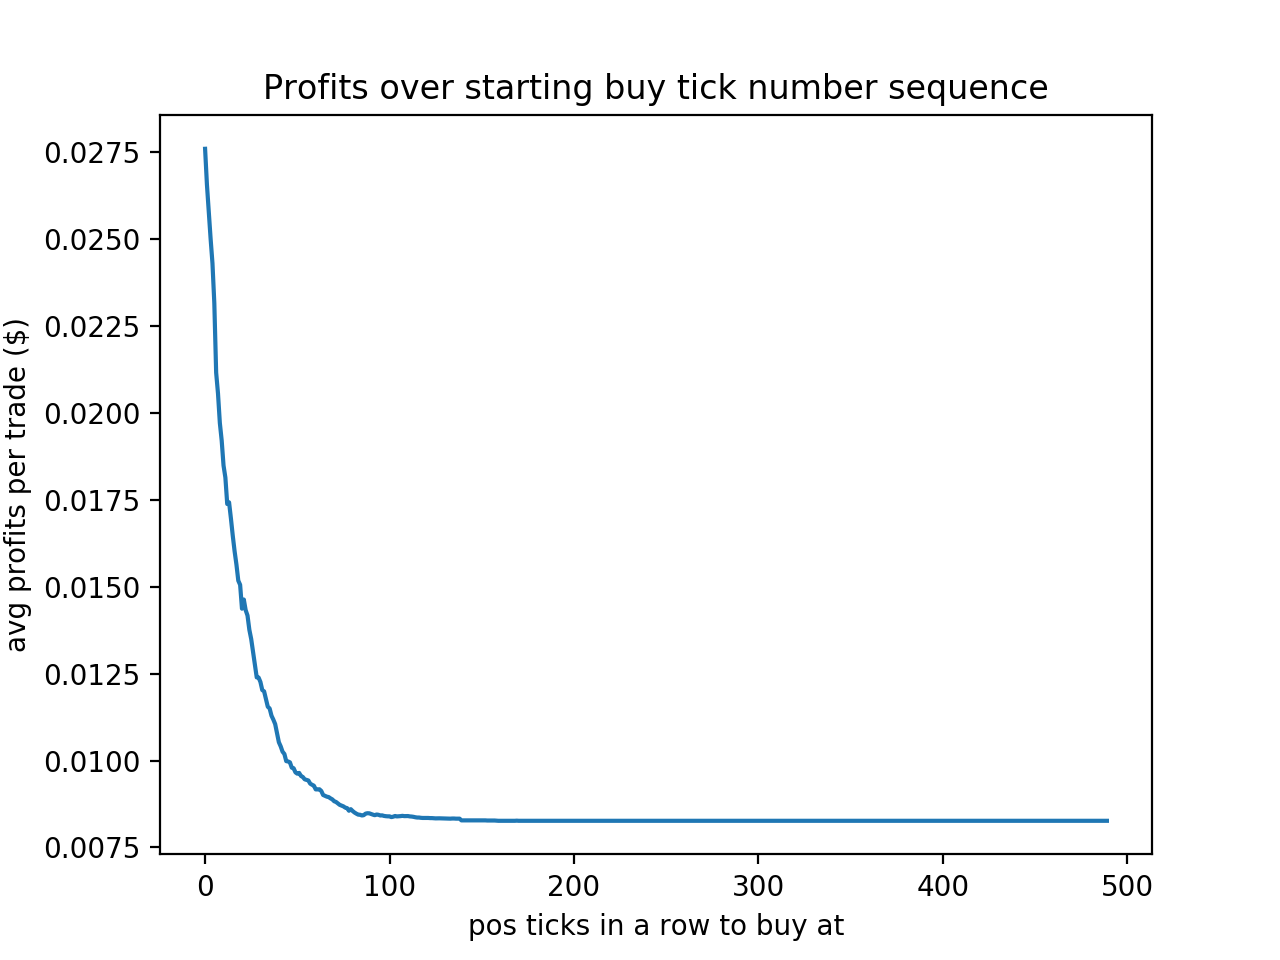

<IPython.core.display.Javascript object>


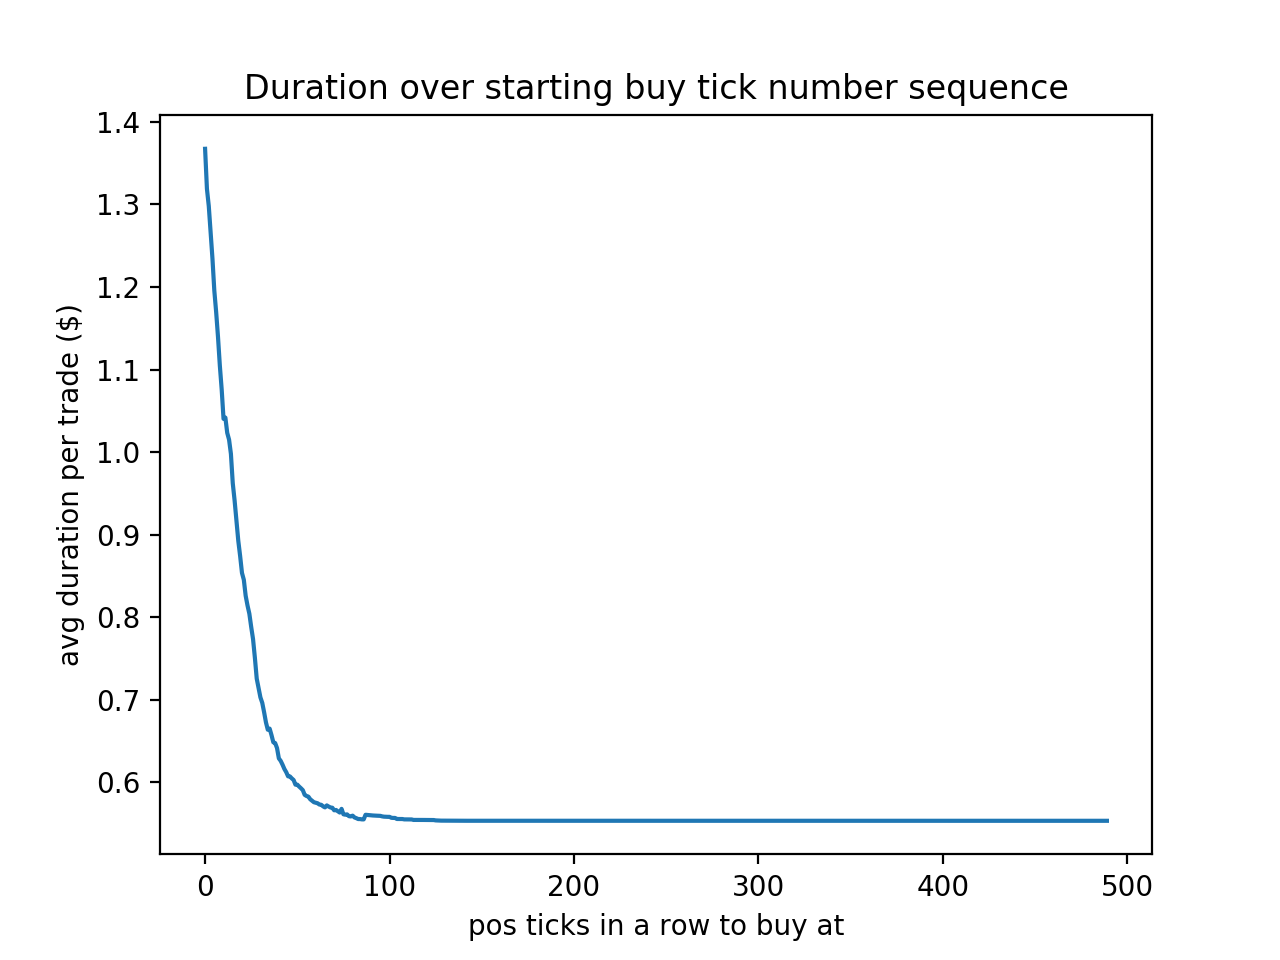

Text(0, 0.5, 'avg duration per trade ($)')

In [42]:
profits = []
duration = []

for bp in range(10, 500):
    pp, dd = test_mom_at(bp)
    profits.append(pp)
    duration.append(dd)
    
plt.figure()
plt.plot(profits)
plt.title("Profits over starting buy tick number sequence")
plt.xlabel("pos ticks in a row to buy at")
plt.ylabel("avg profits per trade ($)")


plt.figure()
plt.plot(duration)
plt.title("Duration over starting buy tick number sequence")
plt.xlabel("pos ticks in a row to buy at")
plt.ylabel("avg duration per trade ($)")

# Examine the VWAP as a buy/sell indicator

In [51]:
def compute_VWAP(dicc, window = timedelta(minutes = 5), acc = timedelta(minutes=1)):
    dicc['sip_ts_np'] = np.array(dicc['sip_timestamp'])
    
    start = datetime.fromtimestamp(dicc['sip_timestamp'][0]*1e-9)
    start_adj = datetime(start.year, start.month, start.day, hour=8, minute=30)
    end = datetime(start.year, start.month, start.day, hour=15)
    
    ct = start_adj + window
    
    tm = []
    vwap = []
    
    while ct < end:
        wnst = (ct-window).timestamp()*1e9
        wnen = ct.timestamp()*1e9
        
        idst = np.argwhere(dicc['sip_ts_np'] <= wnst)
        if len(idst) == 0: idst = 0
        else: idst = idst[-1][0]

        iden = np.argwhere(dicc['sip_ts_np'] >= wnen)
        if len(iden) == 0: iden = len(dicc['sip_timestamp'])-1
        else: iden = iden[0][0]
            
        num = 0
        den = 0
        for ii in range(idst, iden+1):
            num+=dicc['price'][ii]*dicc['size'][ii]
            den+=dicc['size'][ii]
        
        tm.append(wnen)
        vwap.append(num/den)
        
        ct+=acc
    
    return tm, vwap

In [48]:
dicc = one_day['AAPL']
start = datetime.fromtimestamp(dicc['sip_timestamp'][0]*1e-9)
start_adj = datetime(start.year, start.month, start.day, hour=9, minute=30)

print("start - stop: ", start, " - ", start_adj)

start - stop:  2020-04-06 08:30:00.000340  -  2020-04-06 09:30:00


In [52]:
X, VWAP = compute_VWAP(one_day['AAPL'])

<IPython.core.display.Javascript object>


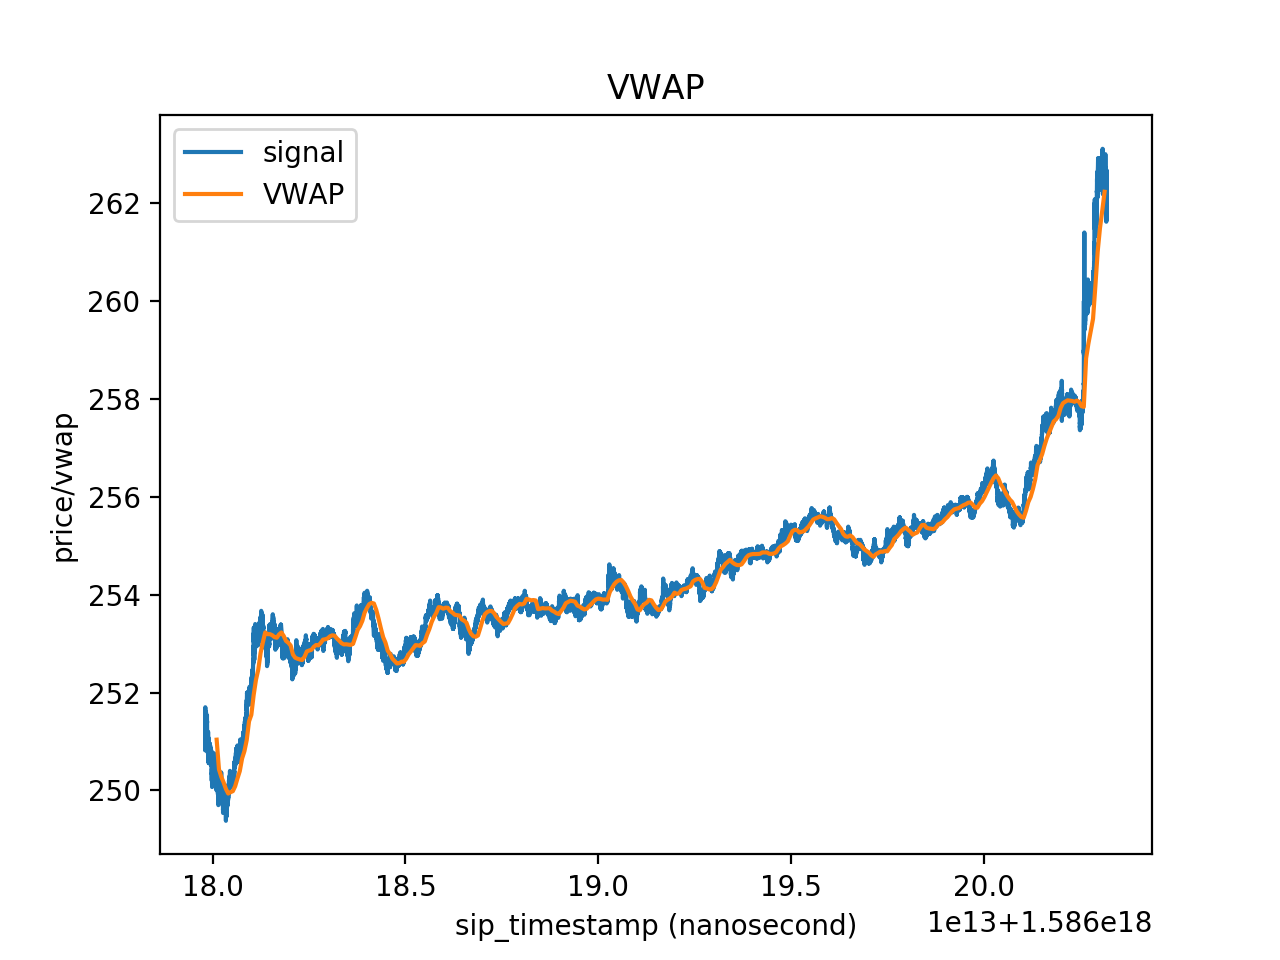

Text(0, 0.5, 'price/vwap')

In [53]:
plt.figure()
plt.plot(one_day['AAPL']['sip_timestamp'], one_day['AAPL']['price'])
plt.plot(X, VWAP)
plt.legend(['signal', 'VWAP'])
plt.title("VWAP")
plt.xlabel("sip_timestamp (nanosecond)")
plt.ylabel('price/vwap')

## Strategy
Long/Short each time the VWAP changes direction.

In [54]:
def backtest_vwap_strat(dicc, xx, vwap, thr = .1, verbose = True):
    dicc['sip_ts_np'] = np.array(dicc['sip_timestamp'])
    if vwap[1]>=vwap[0]:
        going_up = True
    elif vwap[1]<vwap[0]:
        going_up = False
    
    ii = 10
    
    trades = None
    
    while ii < len(vwap):
        if abs(vwap[ii]-vwap[ii-5]) > thr:
            to_trade = True
        else:
            to_trade = False
        
        if going_up:
            if vwap[ii]>=vwap[ii-1]:
                #conitnue because its still going up
                ii+=1
                continue
            else:
                
                    
                ndx = np.argwhere(dicc['sip_ts_np'] >= xx[ii])[0][0]
                if trades is None:
                    if to_trade:
                        trades = []
                        trades.append({'type': 'short', 'in_price': dicc['price'][ndx], 'out_price': None, 
                                   "in_time": dicc['sip_timestamp'][ndx], "out_time" : None})
                else:
                    if trades[-1]['out_price'] is None:
                        trades[-1]['out_price'] = dicc['price'][ndx]
                        trades[-1]['out_time'] = dicc['sip_timestamp'][ndx]
                    if to_trade:
                        trades.append({'type': 'short', 'in_price': dicc['price'][ndx], 'out_price': None, 
                                  "in_time": dicc['sip_timestamp'][ndx], "out_time" : None})
                
                going_up = False
                
                ii+=1
                continue
                
        else:
            # This means the stock is currently going down
            if vwap[ii]<=vwap[ii-1]:
                ii+=1
                continue
            else:
                ndx = np.argwhere(dicc['sip_ts_np'] >= xx[ii])[0][0]
                if trades is None:
                    if to_trade:
                        trades = []
                        trades.append({'type': 'long', 'in_price': dicc['price'][ndx], 'out_price': None, 
                                      "in_time": dicc['sip_timestamp'][ndx], "out_time" : None})
                else:
                    if trades[-1]['out_price'] is None:
                        trades[-1]['out_price'] = dicc['price'][ndx]
                        trades[-1]['out_time'] = dicc['sip_timestamp'][ndx]
                    
                    if to_trade:
                        trades.append({'type': 'long', 'in_price': dicc['price'][ndx], 'out_price': None, 
                                  "in_time": dicc['sip_timestamp'][ndx], "out_time" : None})
                    
                going_up = True
                
                ii+=1
                continue
        
    profits = []
    duration = []
    
    if trades is not None:
        for trade in trades[0:-1]:
            if trade['type'] == 'long':
                profits.append(trade['out_price']-trade['in_price'])
            elif trade['type'] == 'short':
                profits.append(trade['in_price']-trade['out_price'])

            duration.append(trade['out_time']-trade["in_time"])

        duration = list(map(lambda x: x*1e-9, duration))
        
        if verbose:
            print("Profits: AVG = ", statistics.mean(profits), "$, STDEV = ", statistics.stdev(profits))
            print("Duration (sec): AVG = ", statistics.mean(duration), " Min = ", min(duration), " Max = ", max(duration))
            print("Number of trades conducted = ", len(trades))
    pfmn = statistics.mean(profits) if len(profits)>0 else 0
    drmn = statistics.mean(duration) if len(duration)>0 else 0
    return trades, pfmn, drmn

In [56]:
thrs = []
pfs = []
drs = []
for ii in range(0, 500, 5):
    thr = ii/100
    thrs.append(thr)
    trades, pf, dr = backtest_vwap_strat(one_day['AAPL'], X, VWAP, thr=thr, verbose=False)
    pfs.append(pf)
    drs.append(dr)

<IPython.core.display.Javascript object>


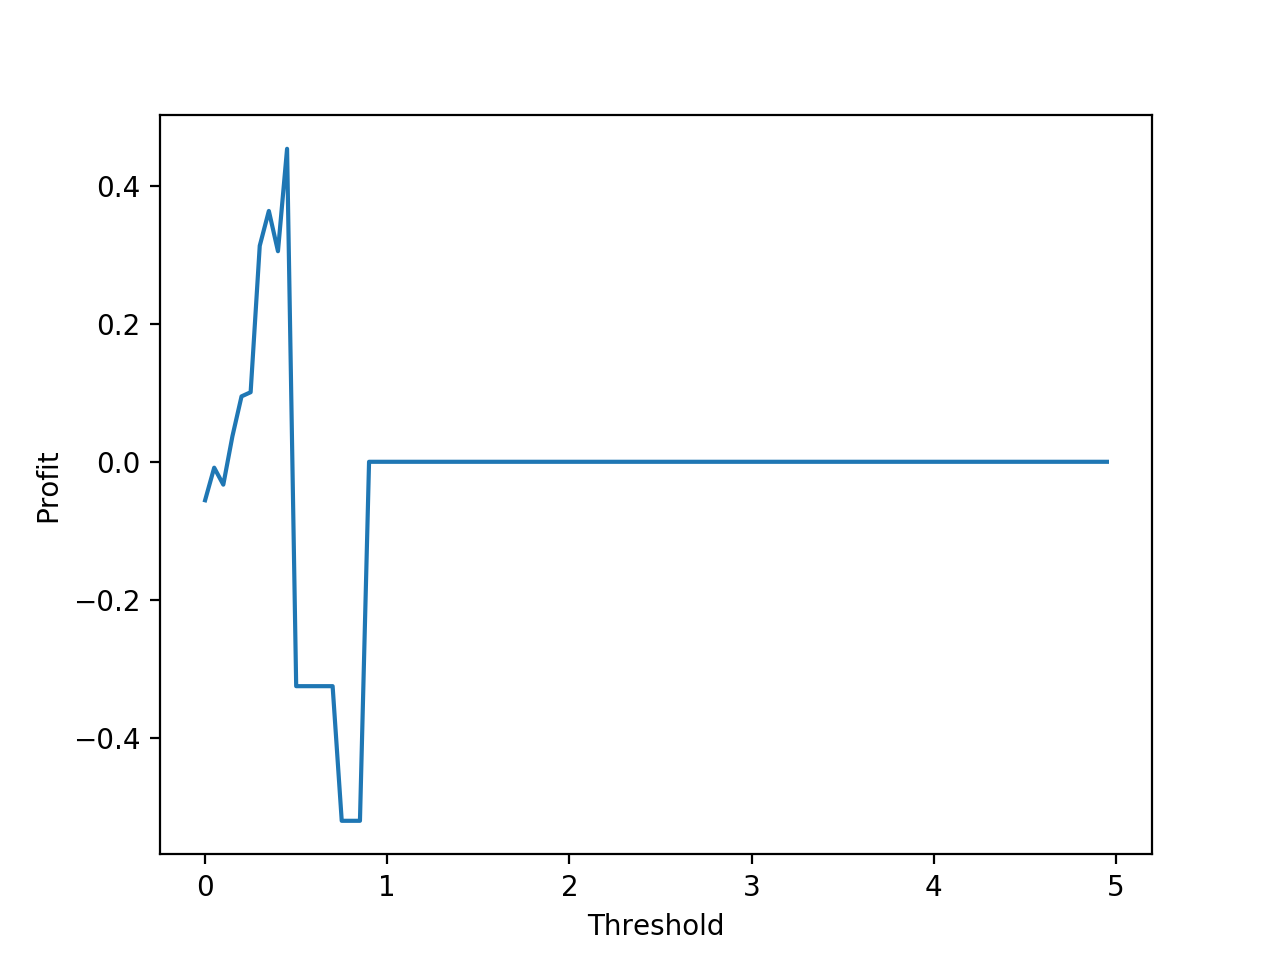

Text(0, 0.5, 'Profit')

In [57]:
plt.figure()
plt.plot(thrs, pfs)
plt.xlabel("Threshold")
plt.ylabel("Profit")

In [58]:
trades, pf, dr = backtest_vwap_strat(one_day['AAPL'], X, VWAP, thr=.35)

Profits: AVG =  0.36333333333332973 $, STDEV =  0.9123084273789571
Duration (sec): AVG =  300.0282766996667  Min =  59.82274884  Max =  720.211312257
Number of trades conducted =  7


Note: the stdev is high here because only 7 trades were conducted. 

In [61]:
cdays = []
for dd in dates:
    cdays.append(load_date(dd))    

prfs = []
drs = []
trades = []

for ii, cday in enumerate(cdays): 
    
    print(str(dates[ii]))
    cx, cvwap = compute_VWAP(cday['AAPL'])
    tt, pf, dr = backtest_vwap_strat(cday['AAPL'], cx, cvwap, thr=.7)
    
    
    prfs.append(pf)
    drs.append(dr)
    
    if tt is not None:
        trades.extend(tt)
    else:
        print("No Trades Conducted")
        
    print("*"*50)

2020-04-06
Profits: AVG =  -0.32500000000000284 $, STDEV =  0.275771644662764
Duration (sec): AVG =  60.0124577535  Min =  59.82274884  Max =  60.20216666700001
Number of trades conducted =  3
**************************************************
2020-04-03
No Trades Conducted
**************************************************
2020-04-02
Profits: AVG =  0.4099999999999824 $, STDEV =  0.5091168824543134
Duration (sec): AVG =  360.13573774400004  Min =  300.06751454600004  Max =  420.20396094200004
Number of trades conducted =  3
**************************************************
2020-04-01
No Trades Conducted
**************************************************
2020-03-31
Profits: AVG =  0.030000000000001137 $, STDEV =  0.04242640687119446
Duration (sec): AVG =  119.22312505050002  Min =  58.704920761000004  Max =  179.74132934000002
Number of trades conducted =  3
**************************************************
2020-03-30
Profits: AVG =  -0.3300000000000125 $, STDEV =  0.3535533905932738

In [62]:
profits = []
duration = []

for trade in trades:
    if trade['out_price'] is None:
        continue
    if trade['type'] == 'long':
        profits.append(trade['out_price']-trade['in_price'])
    elif trade['type'] == 'short':
        profits.append(trade['in_price']-trade['out_price'])

    duration.append(trade['out_time']-trade["in_time"])

duration = list(map(lambda x: x*1e-9, duration))


print("Profits: AVG = ", statistics.mean(profits), "$, STDEV = ", statistics.stdev(profits))
print("Duration (sec): AVG = ", statistics.mean(duration), " Min = ", min(duration), " Max = ", max(duration))
print("Number of trades conducted = ", len(trades))

Profits: AVG =  0.22384615384614484 $, STDEV =  1.0981540455201633
Duration (sec): AVG =  322.9034862604616  Min =  58.704920761000004  Max =  899.904877689
Number of trades conducted =  15
